In [1]:
import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit
from gammapy.spectrum.models import SpectralModel

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor

# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
files ={ 
    'fact':'results/fit/gammapy/fact/fit_results_logparabola.yaml',
    'magic':'results/fit/gammapy/magic/fit_results_logparabola.yaml',
    'fermi':'results/fit/gammapy/fermi/fit_results_logparabola.yaml',
    'hess':'results/fit/gammapy/hess/fit_results_logparabola.yaml',
    'veritas':'results/fit/gammapy/veritas/fit_results_logparabola.yaml',
    'joint':'results/fit/gammapy/joint/fit_results_logparabola.yaml',
}
tels = ['fact', 'magic', 'fermi', 'hess', 'veritas']

I plot the single fit results for the $\beta$ parameter including the estimated standard deviations from the output in the yaml files. This looks just like on would expect and totally fits the countour plots in the paper.


In [69]:
from joint_crab.conf import config
from joint_crab.models import Log10Parabola

standrad log likelihood for poisson -λ+nlog(λ)−log(n!)

In [3]:
def model_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value

def ln_likelihood(theta, n_on, n_off, alpha):
    mu_sig = theta
    likelihood_value = -mu_sig + n_on*np.log(mu_sig)
    return -likelihood_value
    

def ln_prior(theta):
    '''
    Uninformative poisson prior as far as I know. 
    
    See https://en.wikipedia.org/wiki/Jeffreys_prior
    '''
    mu_sig = theta
#     return np.where(mu_sig >= 0, np.log(np.sqrt(1/(mu_sig))), -np.inf) # jeffreys prior would be nice. but how?
    return np.where(mu_sig >= 0, 0, -np.inf)
#     if mu_sig >= 0:
#         return np.sqrt(1/mu_sig)
#     return -np.inf


def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = 0.5*ln_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta)
#         print(f'Mu: {theta}')
#         print(f'prior: {lp}')
        prob = prob + lp
    
    return np.where(np.isfinite(prob), prob, 0)



def model_probability(theta, observations, return_posterior=False):
    amplitude, alpha, beta = theta
#     print(theta)
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    obs_probabilities = []
    for obs in observations:
        mu_sig = model_prediction(model, obs)

        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
#         print([ln_prob(*d) for d in zip(mu_sig, n_on, n_off, obs.alpha)])
#         prob = sum([ln_prob(*d) for d in zip(mu_sig, n_on, n_off, obs.alpha)])
#         prob = sum([wstat(*d, extra_terms=False) for d in zip(n_on, n_off, alpha, mu_sig)])
        prob = ln_prob(mu_sig, n_on, n_off, obs.alpha, return_posterior=return_posterior).sum()            

#             print([ln_prob(*d) for d in zip()])
#             prob =  sum([ln_prob(*d) for d in zip(mu_sig, n_on, n_off, obs.alpha)])
        obs_probabilities.append(prob)
    return -sum(obs_probabilities)
    

In [157]:
dataset = config.get_dataset('magic')
obs_list = dataset.get_SpectrumObservationList()
fit_range = dataset.energy_range

In [158]:
model_probability([3.8, 2.3, 0.4], obs_list, return_posterior=False), model_probability([3.8, 2.3, 0.4], obs_list, return_posterior=True)

[0.00000000e+00 8.02740191e-06 3.90360653e-05 1.47977106e-04
 2.05018003e-04 6.06344294e-04 7.40996216e-04 1.41896593e-03
 2.65319457e-03 6.94682348e-03 1.42738190e-02 4.48030427e-02
 1.46076253e-01 5.37787508e-01 1.55227584e+00 3.25329540e+00
 5.33121790e+00 7.20929633e+00 8.58838334e+00 9.70901731e+00
 1.04299504e+01 1.10521219e+01 1.15676023e+01 1.14394673e+01
 1.15407909e+01 1.17499802e+01 1.13331353e+01 1.12432623e+01
 1.08443955e+01 1.03437871e+01 1.01564697e+01 9.76861896e+00
 8.72898971e+00 7.92686967e+00 7.21425280e+00 6.40152429e+00
 5.69972172e+00 5.00997437e+00 4.28930578e+00 3.75049837e+00
 3.18100753e+00 2.61115586e+00 2.22105303e+00 1.88043598e+00
 1.54269770e+00 1.30706730e+00 1.08262357e+00 8.21000656e-01
 6.30293078e-01 4.86062527e-01 3.70420726e-01 3.00913859e-01
 2.47790957e-01 1.93350617e-01 1.46791590e-01 1.01435351e-01
 6.85374855e-02 4.61071067e-02 2.77583186e-02 1.50610001e-02
 7.33305583e-03 2.72284729e-03 1.16750908e-03 4.18031683e-04
 1.27415650e-04 5.207655

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


(3101.319946216138, 3101.319946216138)

In [146]:
ln_likelihood(theta=16, n_on=10, n_off=10, alpha=0.2), wstat(n_on=10, n_off=10, alpha=0.2, mu_sig=16, extra_terms=False)

(-23.966469777482423, array([-47.93293955]))

In [147]:
N = 25
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    zs.append(model_probability([4, alpha, beta], obs_list))
#     print(model_probability([3.8, alpha, beta], obs_list, return_posterior=True))
    zs_post.append(model_probability([4, alpha, beta], obs_list, return_posterior=True))

zs = np.array(zs)
zs_post = np.array(zs_post)


625it [00:10, 60.39it/s]


Text(0,0.5,'beta')

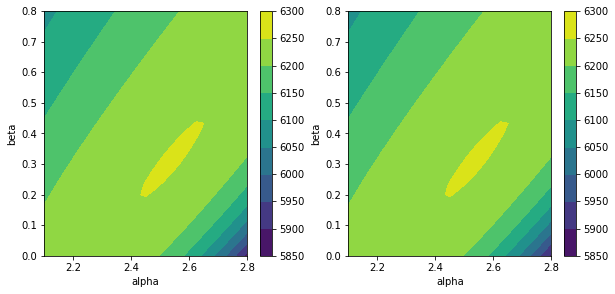

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1), )
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), )
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [149]:
from scipy.optimize import minimize
result = minimize(lambda *x: -model_probability(*x), x0= [3.8, 2.6, 0.4], args=(obs_list, True))
result

      fun: -6250.998981785822
 hess_inv: array([[ 0.08077905, -0.00858821,  0.00254089],
       [-0.00858821,  0.00762121,  0.00705578],
       [ 0.00254089,  0.00705578,  0.00923115]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([4.06177451, 2.52945996, 0.31229789])

In [127]:
import emcee
ndim, nwalkers = 3, 75
pos = np.array([result.x + 0.1 * np.random.randn(ndim) for i in range(nwalkers)])
# print(pos)
sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, True), threads=2)
sampler_output = sampler.run_mcmc(pos, 200, progress=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 200/200 [02:27<00:00,  1.38it/s]


In [128]:
samples = sampler.chain[:, 25:, :]
samples.shape
# samples[:, :, 0] b
# samples[:, :, 0]


(75, 175, 3)

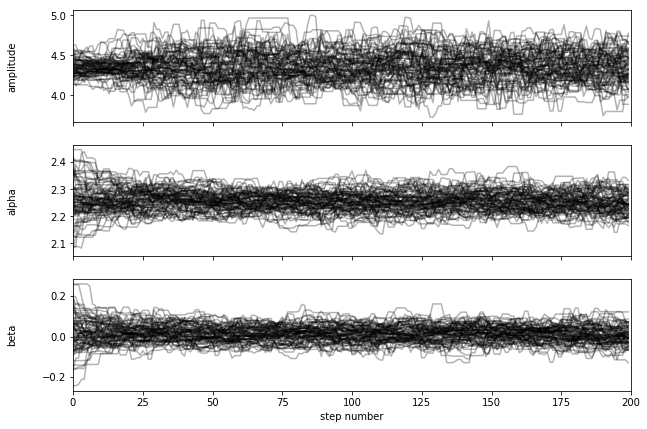

In [131]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["amplitude", "alpha", "beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, len(sampler.chain[0]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


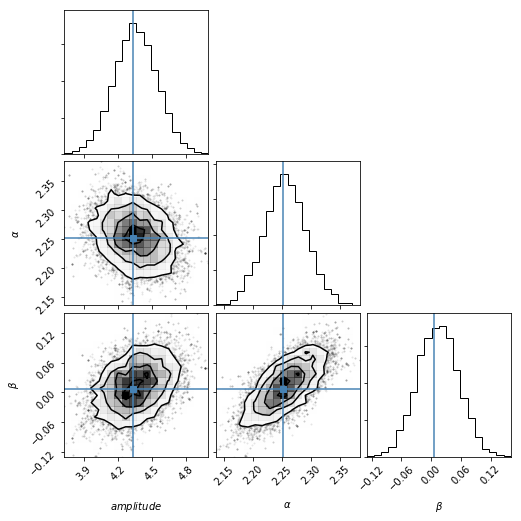

In [132]:
import corner
fig = corner.corner(samples.reshape(-1, ndim), labels=["$amplitude$", "$\\alpha$", "$\\beta$"], truths=result.x)